### Introduction - Navier-Stokes driven cavity problem with PETSc in Proteus.


This notebook illustrates how to setup, solve and visualize a steady-state Navier-Stokes driven-cavity problem in Proteus using solver tools from the PETSc linear algebra library.


The driven-cavity problem is a standard benchmark for modeling Stokes and Navier-Stokes equations.  The simulation models a self-contained (i.e. no inflow or outflow) tank of fluid with an external force generating a velocity along the top of the tank.  For example, one could imagine a fan blowing over the top of an open fish tank full of water, causing water at the tank's surface to move at a non-trivial velocity. One reference that provides a deeper discussion of this problem is "Finite Elements and Faster Iterative Solvers" by Elman, Silvester and Wathen.


The governing equations for our problem are the Navier-Stokes equations which we present in non-dimensional form.  Let $p: \Omega \rightarrow \mathbf{R}$, $\mathbf{v}:\Omega \rightarrow \mathbf{R} \times \mathbf{R}^n$ denote the unknown pressure and velocity of the system.  The Navier-Stokes equation relate these quantities through
$$
\nabla \cdot \mathbf{v}  = 0 
$$
$$
- \dfrac{1}{Re} \nabla \cdot (\nabla \mathbf{v}) + \mathbf{v} \cdot \nabla \mathbf{v} + \nabla p = \mathbf{f},
$$
where $Re$ is the Reynolds number and $\mathbf{f}$ is an external force.  As $Re$ increases, the non-linear convection term becomes more dominate to the system's behavior while as $Re$ decreases the the diffusion term will become more important to the system's behavior.  In many real world problems, $Re$ assumes a very large value, which results in a convection dominated system that is very challenging to solve numerically.

In this example, we are interested in solving this system for $Re$ up to 1000.

Our domain of interest is a 2D square tank
$$
\Omega = [-1,1]^{2}
$$
 with Dirichlet boundary conditons
$$
\mathbf{v} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} \text{ for } \Gamma_{\text{top}}
$$
and
$$
\mathbf{v} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} \text{ for } \Gamma_{\text{bottom}}, \Gamma_{\text{right}}, \Gamma_{\text{left}}.
$$


### Initialze Proteus Library

This first block loads and initialzes the libraries needed to run the simulation.  numpy and petsc4py are external libraries that support Proteus' linear algebra operations.  The proteus.iproteus command loads the interacitve proteus library.

The profiling commands enable output allowing us to track the progress of our simulation.  Increasing the log level will display more output.

In [1]:
import numpy as np
import petsc4py as petsc4py
from proteus.iproteus import * 

Profiling.logLevel = 3
Profiling.verbose = True

### Boundary Conditions

Boundary conditions are critical to any numeric PDE solver.  In the next block of code we define two functions that will help use to specify problems boundary conditions. 

You may notice that uTrue does not simply return 1 for the top velocity.  In this example we will use a Newton Interation to solve the Navier-Stokes system.  As is well known, Newton iterations converge quadratically, but only if the initial guess is sufficiently close to the solution.  For Navier-Stokes problems, as the Reynolds number increases, this convergence ball gets smaller and smaller.

Therefore, to solve a driven cavity problem with $Re=1000$, an initial guess of 0 is not good enough.  Instead, we solve a sequence of NS problems with increasing $Re$, and use the solution of the previous iteration as the initial guess for a new problem with a larger $Re$ number.  One way of accomplishing this in Proteus is to treat each successive solve as a time-step.

Another point to consider is that since we are only specifying Dirichlet conditions, the system's pressure can only be solved up to a constant.  This means that the linear system we need to solve has a non-trivial null space.  In this tutorial, we won't focus on this issue, rather than mention that the linear solver deals with this null space 'under-the-hood'.

In [2]:

class uTrue:
    def __init__(self):
        pass
    def uOfX(self,x):
        return 1.
    def uOfXT(self,x,t):
        return 10.0**max(0.0,t-1.0)
        
class vTrue:
    def __init__(self):
        pass
    def vOfX(self,x):
        return 0.
    def vOfXT(self,x,t):
        return self.vOfX(x)


### The Proteus Phliosophy

Before proceeding, it is worth noting that simulations designed in Proteus seperate the problem's physics and the numerics.  This approach allows researchers with different focuses study on the specific features of their problem. Next we discuss how to set up the driven-cavity physics and experiment with a variety of numerics.

### Define the Physics

The first step in defining a problem's physics is to call default_p.  default_p is a collection of default values for the various physics parameters the Proteus solver expects.  After initializing default_p, we override many of the defaults to build the driven cavity NS problem we are interested in solving.  See the inline comments for details.


In [3]:
physics = default_p
physics.name = "nse_driven_cavity"

# this specifies the problem's dimension
physics.nd = 2

# There are several ways to specify a mesh in Proteus.  Perhaps the eaiset is to initialize
# a coordinate for the bottom left corner of the mesh (.x0) and the length of each coordinate
# axis (.L).
# Thus, the commands below creates a mesh with length 1 in the x and y direction with its bottom 
# left corner at the origin.
physics.x0 = [-1.0,-1.0]
physics.L = [2.0,2.0]

# Here we specify the simulation coefficients will come from a NavierStokes problem. Note that Proteus 
# has prewritten classes for most common physics problems.
physics.coefficients = TransportCoefficients.TwophaseNavierStokes_ST_LS_SO(epsFact=0.0,
                                                                           sigma=0.0,
                                                                           rho_0=1.0,
                                                                           nu_0=1.0,
                                                                           rho_1=1.0,
                                                                           nu_1=1.0,
                                                                           g=[0.0,0.0],
                                                                           nd=2,
                                                                           LS_model=None,
                                                                           KN_model=None,
                                                                           epsFact_density=None,
                                                                           stokes=False);

# Next we define functions for our problem's boundary conditions.  Note that these functions
# refer to the earlier boundary condition functions and are not memebers of the the physics class.
def top(x,flag):
    if x[1]== physics.x0[1]+physics.L[1]:
        return True
    else:
        return False

def sides(x,flag):
    if (x[0]==physics.x0[0] or x[0]==(physics.x0[0]+physics.L[0])):
        return True
    else:
        return False

def bottom(x,flag):
    if (x[1] == physics.x0[1]):
        return True
    else:
        return False
        
def getDBCp(x,flag):
    pass

def getDBCu(x,flag):
    if sides(x,flag) or bottom(x,flag):
        return lambda x,t: 0.0
    elif top(x,flag):
        return lambda x,t: uTrue().uOfXT(x,t)

def getDBCv(x,flag):
    if (top(x,flag) or sides(x,flag) or bottom(x,flag)):
        return lambda x,t: 0.0

def getAdvFluxBCp(x,flag):
    pass
    
def getAdvFluxBCu(x,flag):
    pass

def getAdvFluxBCv(x,flag):
    pass
    
# Here we attach the boundary condition functions written above to Proteus' physics class.  For this
# problem, the boundary conditions are fully specified by the Dirichlet conditions along the boundary.
# The boundary conditions corresponding to the advectiveFlux and pressure are just place holders.
physics.dirichletConditions = {0:getDBCp, 1:getDBCu, 2:getDBCv}
physics.advectiveFluxBoundaryConditions = {0:getAdvFluxBCp,1:getAdvFluxBCu,2:getAdvFluxBCv}

### Define the Numerics

As with the phyiscs, we load default_n to initialize the numerics.

Following the initialization, we specify information on the: Mesh, FE Space, Linear Algebra and Solver Options, Numerical Flux and Post-Processing.

**Mesh**

While the dimensions and location of the domain are speicified as part of the simulation's physics, aspects of the refinment are speicifed as part of the simulation's numerics.  In this example, we specify the number of nodes on each coordinate axis of the mesh.  While other mesh options are avaliable, these will be demonstrated in other tutorials.

**FE Space**

Proteus supports several choices of finite elements to solve Stokes and Navier-Stokes problems.  In this example we illustrate how to specify Taylor-Hood (TH, TH_Quads) and stablized linear elements (C0P1C0P1, C0Q1C0Q1) on triangular and quadrilateral meshes.

**Linear Algebra and Solver Options**

We start with the non-linear solver.  (Note - Proteus currently only supports a Newton Iteration for the non-linear solver type but in the future users will be able to select a Picard Iteration as well.)  Users need to select the maximum non-linear iterations and line searches for the Newton Iteration.  In general, these values should not be too high as excessive iterations usual indicate the scheme is failing to converge.

Next specify the linear solver.  The first choice is whether to solve the system using a direct or iterative method.  If possible, when first running a simulation, it is usually a good idea to start with a direct solver (of course, many simulations will be too large for a direct solver).  This will allow us to check that the non-linear solver is converging properly.

After verifying everything is working with the non-linear solver, we can start experimenting with iterative solvers. In this tutorial, we will show how to use PETSc's flexible-gmres Krylov solver. 

High Reynolds number NS problems are notoriously difficult to solve with iterative solvers because of their poor conditioning.  Indeed, effective preconditioning for these problems remains an active field of research in numerical analysis.  One of the most effective preconditioning strategies is the Schur Complement, which takes advantage the block structure arising from the problem's physics to first solve for the pressure unknowns.  Once the pressure is known, it is a relatively easy to solve for the velocity.

In the script below, we specify a PETSc iterative solver (see the ksp_type option) and preconditioner (see the pc_type option) using the PETSc4py tool.  In the LinearSolvers.NavierStokes2D, Proteus specifies which unknowns correspond to velcoity and pressure.  This allows us to further specify a solver and preconditioner for the velocity block.

A full descirption of the Schur complement is beyond the scope of this tutorial, but there are many excellent resources avaliable including the text "Finite Elements and Faster Iterative Solvers" by Elman, Silvester and Wathen.  One comment we will make is that the built in preconditioners avaliable through PETSc (for example selfP) are not terribly effective for solving the Schur block for high Reynolds number NSE.  In these cases more effective Schur approximations and preconditioners are needed. 

**Numerical Flux Options**

Finally, the problem's boundary conditions can also be enforced using a penalty method (see the paper Unified Analysis of Discontinuous Galerkin Methods For Elliptical Problems).  This option is set as part of the problems numerics using the numericalFluxType flag.  When the solver is set to iterative, Proteus requires the numericaFluxType be set in order for the degrees of freedom to interface with PETSc correctly.

**Post-Processing**

Neither stablized nor Taylor-Hood finite element schemes generate conservative velocity fields for the NSE. Proteus allows users to post-process their numerical solutions to become conservative.  The approach follows the Larson-Niklasson scheme discussed in the paper 'A conservative flux for the continuous Galerkin method based on discontinuous enrichment'.  Once the velocity has been made conservative, it is then projected into the $BDM_{1}$ space. 

In [4]:
numerics = default_n

# ******* MESH ********
# this specifies the number of mesh nodes in the x and y directions 
numerics.nn = 71

# ******* FE SPACE *********
# these options specify the finite element space used to approximate the solution

numeric_scheme = "TH" # ***** Options: TH, C0P1C0P1, TH_Quads, C0Q1C0Q1

if numeric_scheme == "TH":
    numerics.femSpaces = {0:FemTools.P1,  #pressure space
                          1:FemTools.P2,
                          2:FemTools.P2}  #velocity space

elif numeric_scheme == "C0P1C0P1":
    numerics.femSpaces = {0:FemTools.P1,
                          1:FemTools.P1,
                          2:FemTools.P1}
    numerics.subgridError = SubgridError.NavierStokesASGS_velocity_pressure(physics.coefficients,physics.nd,lag=False)

elif numeric_scheme == "TH_Quads":
    numerics.femSpaces = {0:FemTools.Q1,
                          1:FemTools.Q2,
                          2:FemTools.Q2}
    
elif numeric_scheme == "C0Q1C0Q1":
    numerics.femSpaces = {0:FemTools.Q1,
                          1:FemTools.Q1,
                          2:FemTools.Q1}
    subgridError = SubgridError.NavierStokesASGS_velocity_pressure(physics.coefficients,physics.nd,lag=False)
    
else:
    assert 0, 'Invalid element choice'
    
if numeric_scheme == "TH" or numeric_scheme == "C0P1C0P1":
    numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,4)
    numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,4)

elif numeric_scheme == "C0Q1C0Q1" or numeric_scheme == "TH_Quads":
    numerics.quad = True
    numerics.elementQuadrature = Quadrature.CubeGaussQuadrature(physics.nd,4)
    numerics.elementBoundaryQuadrature = Quadrature.CubeGaussQuadrature(physics.nd-1,4)

    
# ******** LINEAR ALGEBRA, SOLVER AND NUMERICAL FLUX OPTIONS ********
    
numerics.matrix = LinearAlgebraTools.SparseMatrix

numerics.multilevelNonlinearSolver = NonlinearSolvers.Newton
numerics.levelNonlinearSolver = NonlinearSolvers.Newton
numerics.maxNonlinearIts = 15
numerics.maxLineSearches = 10

numerics.linearSmoother = LinearSolvers.NavierStokes2D
numerics.l_atol_res = 1.0e-4
numerics.nl_atol_res = 1.0e-8

solveIteratively = False   # ***** Options : True or False
iterativeSolver = 'schur'  # ***** Options : 'schur'
# NOTE - so far the schur complement preconditioner is not good enough to solve the problem for Re=1000 

if solveIteratively:
    numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
    numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
    if iterativeSolver == 'schur':
        petsc4py.PETSc.Options().setValue("ksp_type","fgmres")
        petsc4py.PETSc.Options().setValue("pc_type","fieldsplit")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_type","schur")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_precondition","selfp")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_schur_fact_type","full")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_detect_saddle_point","")
        petsc4py.PETSc.Options().setValue("fieldsplit_velocity_ksp_type","preonly")
        petsc4py.PETSc.Options().setValue("fieldsplit_velocity_pc_type","lu")
        petsc4py.PETSc.Options().setValue("fieldsplit_pressure_ksp_constant_null_space","")
        petsc4py.PETSc.Options().setValue("fieldsplit_pressure_ksp_max_it","1500")
        petsc4py.PETSc.Options().setValue("fieldsplit_pressure_ksp_monitor_true_residual","")
    numerics.numericalFluxType = NumericalFlux.NavierStokes_Advection_DiagonalUpwind_Diffusion_IIPG_exterior
else:
    numerics.multilevelLinearSolver = LinearSolvers.LU
    numerics.levelLinearSolver = LinearSolvers.LU
    numerics.numericalFluxType = None   # ****** Options: None or 
                                        # NumericalFlux.NavierStokes_Advection_DiagonalUpwind_Diffusion_IIPG_exterior
    
# ********* POST PROCESSING OPTIONS ************

numerics.conservativeFlux = {0: 'pwl-bdm'}

### Initialize SO

This last set of initializations helps us run the drivien cavity simulation for higher Reynolds numbers.  To ensure Newton iteration's initial guess is close enough for the true solution to converge, we solve a sequence of NSE problems using the previous solution as input into the next problem.

The second argument in the np.linspace function determines the final Reynolds number calcuated in the simulation (a value of 4 corresponds to $Re$ = 2000).  

In [5]:
so = default_so
so.name = physics.name
so.sList = [default_s]
so.tnList = np.linspace(0.0,3.5,10).tolist()

### Solve the Problem

In [6]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')

[       5] Initializing NumericalSolution for nse_driven_cavity
 System includes: 
nse_driven_cavity

[       5] Setting Archiver(s)
[       6] Setting up MultilevelMesh
[       6] Building one multilevel mesh for all models
[       6] Generating mesh for nse_driven_cavity
[       6] Building 71 x 71 rectangular mesh for nse_driven_cavity
[       6] Partitioning mesh among 1 processors using partitioningType = 0
[       6] Number of Subdomain Elements Owned= 9800
[       6] Number of Subdomain Elements = 9800
[       6] Number of Subdomain Nodes Owned= 5041
[       6] Number of Subdomain Nodes = 5041
[       6] Number of Subdomain elementBoundaries Owned= 14840
[       6] Number of Subdomain elementBoundaries = 14840
[       6] Number of Subdomain Edges Owned= 14840
[       6] Number of Subdomain Edges = 14840
[       6] Finished partitioning
[       6] *** Global ***
Number of triangles  : 9800
Number of edges : 14840
Number of nodes : 5041

*** Local ***
Number of triangles  : 9800
N

False

### Visualize the Solution

In [7]:
# save solution and grid data for plotting purposes
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
p = ns.modelList[0].levelModelList[-1].u[0].dof
u = ns.modelList[0].levelModelList[-1].u[1].dof
v = ns.modelList[0].levelModelList[-1].u[2].dof

# a different grid is needed for TH on Quads
if numeric_scheme == 'TH_Quads':
    num_DOF = ns.modelList[0].levelModelList[-1].u[1].femSpace.dofMap.lagrangeNodesArray.shape[0]
    x_ref = np.zeros((num_DOF,))
    y_ref = np.zeros((num_DOF,))
    for dof_idx in range(num_DOF):
        x_ref[dof_idx] = ns.modelList[0].levelModelList[-1].u[1].femSpace.dofMap.lagrangeNodesArray[dof_idx][0]
        y_ref[dof_idx] = ns.modelList[0].levelModelList[-1].u[1].femSpace.dofMap.lagrangeNodesArray[dof_idx][1]

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


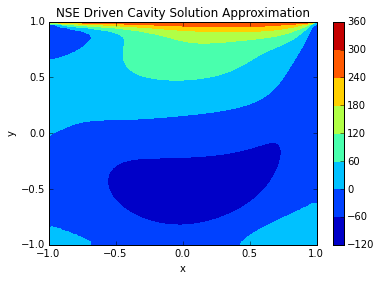

In [9]:
import matplotlib.pyplot as plt
plt.clf()

if numeric_scheme == 'TH' or numeric_scheme=='C0P1C0P1':
    plt.tricontourf(x,y,triangles,u[:x.shape[0]])
elif numeric_scheme == 'C0Q1C0Q1':
    plt.tricontourf(x,y,u)
elif numeric_scheme == 'TH_Quads':
    plt.tricontourf(x_ref,y_ref,u)

plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()


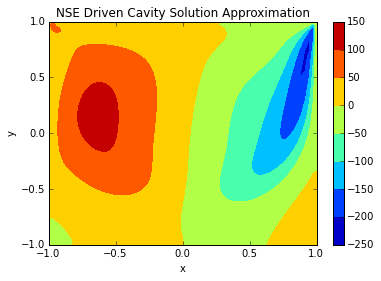

In [10]:
import matplotlib.pyplot as plt
plt.clf()
if numeric_scheme == 'TH' or numeric_scheme=='C0P1C0P1':
    plt.tricontourf(x,y,triangles,v[:x.shape[0]])
elif numeric_scheme == 'C0Q1C0Q1':
    plt.tricontourf(x,y,v)
elif numeric_scheme == 'TH_Quads':
    plt.tricontourf(x_ref,y_ref,v)
    
plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()

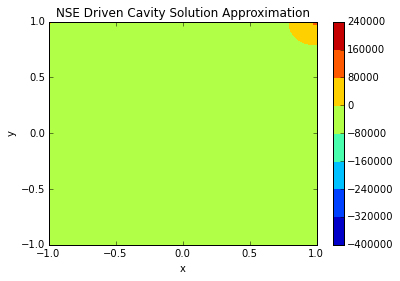

In [11]:
import matplotlib.pyplot as plt
plt.clf()
if numeric_scheme == 'TH' or numeric_scheme=='C0P1C0P1':
    plt.tricontourf(x,y,triangles,p[:x.shape[0]])
elif numeric_scheme == 'C0Q1C0Q1':
    plt.tricontourf(x,y,p)
elif numeric_scheme == 'TH_Quads':
    plt.tricontourf(x,y,p)

plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()